In [ ]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
from collections import Counter


In [ ]:
tickers = pd.read_csv('Tickers.csv', header=None)

# Constant Definitions
max_volume = 200000
min_trading_days = 20
start_date = date(2022, 1, 1)
end_date = date(2022, 10, 31)


valid_tickers = []
tickers_history = []
remaining_tickers = []

for i in range(0, len(tickers)):
    temp_start = start_date
    
    # ensure that the ith ticker corresponds to a listed stock
    is_valid = True
    try:
        ticker = yf.Ticker(tickers.iloc[i][0])
        
        # store the ticker info in memory to avoid multiple calls to the API
        ticker_info = ticker.info
        
        # only append stocks, not ETFs
        if 'quoteType' in ticker_info:
            if ticker_info['quoteType'] == 'ETF':
                print("{0} is not an equity".format(tickers.iloc[i][0]))
                is_valid = False
        
        # only append stocks that are not duplicates of already stored valid tickers 
        if ticker_info['symbol'] in remaining_tickers:
            print("{0} is a duplicate ticker".format(tickers.iloc[i][0]))
            is_valid = False
            
            
        if is_valid:
            if 'currency' in ticker_info:
                ticker_currency = ticker.info['currency']
            elif 'financialCurrency' in ticker_info:
                ticker_currency = ticker.info['financialCurrency']
            else:
                is_valid = False
                print("{0} has no currency information.".format(tickers.iloc[i][0]))
        
    except:
        print("{0} is an invalid or delisted ticker".format(tickers.iloc[i][0]))
        is_valid = False
    
    
    if is_valid:    
        monthly_hist = ticker.history(start=start_date, end=end_date, interval='1mo')
        
        # if they don't have closing prices or symbol 
        if 'previousClose' not in ticker_info or 'symbol' not in ticker_info: 
            print("{0} doesn't have sufficient data".format(tickers.iloc[i][0]))
            is_valid = False
        
        if is_valid:
            # only include US listed stocks with average monthly volume greater than or equal to max_volume are selected
            if ticker_currency == 'USD' and monthly_hist['Volume'].mean() >= max_volume:
                daily_hist = ticker.history(start=start_date, end=end_date, interval='1d')

                # include only months with a number of trading days greater than or equal to min_trading_days days
                while temp_start <= end_date:
                    month_length = len(daily_hist[(daily_hist.index >= str(temp_start)) & (daily_hist.index <= pd.to_datetime(temp_start + relativedelta(months=1)))])
                    if month_length < min_trading_days:
                        daily_hist.drop(daily_hist[(daily_hist.index >= str(temp_start)) & (daily_hist.index <= pd.to_datetime(temp_start + relativedelta(months=1)))].index.values, axis=0, inplace=True)
                    temp_start += relativedelta(months=1)

                valid_tickers.append(ticker)
                tickers_history.append(daily_hist)
                remaining_tickers.append(ticker_info['symbol'])
            else:
                print("{0} does not meet the required stock denomination or volume requirement".format(tickers.iloc[i][0]))


    
        
  

- ACRV: Data doesn't exist for startDate = 1641013200, endDate = 1667188800
ACRV does not meet the required stock denomination or volume requirement
asdfa is an invalid or delisted ticker
INVALIDTIC is an invalid or delisted ticker
HDFC.NS does not meet the required stock denomination or volume requirement
CELG is an invalid or delisted ticker
SHOP is a duplicate ticker
T.TO does not meet the required stock denomination or volume requirement
SHOP is a duplicate ticker
COST is a duplicate ticker
QQQ is not an equity


In [ ]:
# initialize variables
closing_prices = pd.DataFrame()
daily_returns = pd.DataFrame()
expected_return = []
industries = []

# load yfinance data into DataFrames and lists
for i in range(len(valid_tickers)):
    closing_prices[valid_tickers[i].info['symbol']] = tickers_history[i]['Close']
    daily_returns[valid_tickers[i].info['symbol']] = closing_prices[valid_tickers[i].info['symbol']].pct_change()
    expected_return.append(daily_returns.iloc[i].mean() * 100)
    
# number of stocks to put into the portfolio
n = 12

In [ ]:
# create_portfolio generates a portfolio of stocks by adding the stock most correlated to an already formed portfolio of at least one stock
# until tickers_needed number of stocks is reached

# create_portfolio: list list DataFrame Nat Nat DataFrame
def create_portfolio(tickers_added, remaining_tickers, pw_index_of_tickers_added, num_tickers_added, tickers_needed, daily_returns):
    
    if num_tickers_added == tickers_needed:
        # need to return a list of tickers added AND the price weighted index of the evenly distributed portfolio
        return [tickers_added, pw_index_of_tickers_added]
    else:
        # create a dataframe with the price weighted index and remaining tickers not added to the index so far
        daily_returns_new = daily_returns[remaining_tickers]
        daily_returns_new.insert(0, 'PWI', pw_index_of_tickers_added.pct_change())

        # find the stock with the highest correlation to add to the price weighted index
        correlation_df = daily_returns_new.corr()
        series_stocks = correlation_df.iloc[0].replace(1, np.nan)
        stock_to_add = series_stocks.idxmax()
        
        # add the stock to the price weighted index
        pw_index_of_tickers_added += closing_prices[stock_to_add] / closing_prices[stock_to_add][0]
        tickers_added.append(stock_to_add)
        num_tickers_added += 1
        
        # remove the ticker from the list of remaining tickers      
        remaining_tickers.remove(stock_to_add)
        
        # recurse on the remaining available tickers
        return create_portfolio(tickers_added, remaining_tickers, pw_index_of_tickers_added, num_tickers_added, tickers_needed, daily_returns)

    
def main(N, k, portfolios, remaining_tickers, daily_returns):
    if init_len - N == n:
        pf_stds = []
        for i in range(len(portfolios)):
            # append the standard deviations of each portfolio to a list
            pf_stds.append(portfolios[i][1].pct_change().std())
        
        # get maximum standard deviation portfolio
        loc = pf_stds.index(max(pf_stds))
        return portfolios[loc][0]
    else:
        # create a correlation matrix of all stocks in daily_returns DataFrame
        correlation_df = daily_returns.corr()

        # replace correlation of 1 with Nan values
        correlation_df.replace(1, np.nan, inplace=True)

        # find the two stocks with max correlation
        series_stocks = correlation_df.max()
        first_stock = series_stocks.idxmax(axis=0, skipna=True)
        series_stocks.drop(first_stock, inplace=True)
        second_stock = series_stocks.idxmax(axis=0, skipna=True)

        # create price weighted index (setting the initial price of each stock to $1)
        price_weighted_index = closing_prices[first_stock] / closing_prices[first_stock][0] + closing_prices[second_stock] / closing_prices[second_stock][0]
        
        temp_tickers = remaining_tickers.copy()
        
        temp_tickers.remove(first_stock)
        temp_tickers.remove(second_stock)
        
        pf = create_portfolio([first_stock, second_stock], temp_tickers, price_weighted_index, 2, 12, daily_returns)

        portfolios.append(pf)

        # remove the stock with the lowest standard deviation from the list of stocks
        stock_to_drop = daily_returns.std().idxmin()
        
        # drop from both the dataframe AND the list of ticker names
        daily_returns.drop(stock_to_drop, axis=1, inplace=True)

        remaining_tickers.remove(stock_to_drop)
     
        # recurse on the remaining_tickers, having added one of them to the portfolio, getting closer to the base case
        return main(N-1, k, portfolios, remaining_tickers, daily_returns)
        
# create a list of remaining tickers stored as a list of strings         
remaining_tickers = [valid_tickers[i].info['symbol'] for i in range(len(valid_tickers))]

# retrieve a list of possible portfolios with the highest correlation
init_len = len(valid_tickers)
p = main(init_len, n, [], remaining_tickers, daily_returns)

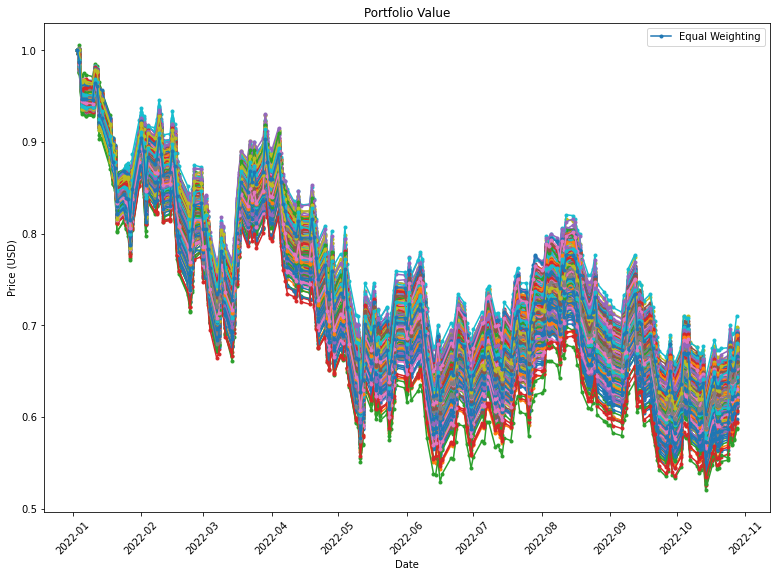

In [5]:
# initializing boundaries 
lower = 1/(2*n)
upper = 0.25

# number of test weights
trials = 1000
weights = []
ticker_names = [valid_tickers[i].info['symbol'] for i in range(len(valid_tickers))]

# generate "trials" amount of test weights
for i in range(trials):
    valid_weight = False
    while not valid_weight:
        temp = np.array(np.random.random(n))
        temp /= np.sum(temp)
        
        # ensure the generated test weights are within the given interval
        if np.all(temp >= lower) and np.all(temp <= upper):
            valid_weight = True
            weights.append(temp)

# create an equally weighted portfolio with n stocks where each stock has an initial value of $1 in the portfolio
pf = pd.DataFrame()

for i in range(n):
    pf[p[i]] = closing_prices[p[i]] / closing_prices[p[i]].iloc[0]
    
pf['Portfolio'] = pf.sum(axis=1)


# display the portfolio
plt.figure(figsize=(13,9))
plt.plot(pf.index, pf['Portfolio'] / n, marker='.', label='Equal Weighting') # division by n to scale the portfolio down

plt.title("Portfolio Value")
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel("Price (USD)")
plt.legend()

pf_diff = []
for w in weights:
    pf_temp = pd.DataFrame()
    
    # create portfolio of the n stocks in p, with a weighting of val assigned to each (i+1)th stock
    i = 0
    for val in w:
        pf_temp[p[i]] = pf[p[i]] * val
        i += 1
        
    pf_temp['Portfolio'] = pf_temp.sum(axis=1)
    
    # append the absolute difference between the start and end price to a related list
    pf_diff.append(abs(pf_temp['Portfolio'].iloc[0] - pf_temp['Portfolio'].iloc[-1]))
    
    # plot portfolio p with weightings corresponding to w
    x = pf_temp.index
    y = pf_temp['Portfolio']
    plt.plot(x, y, marker='.')

optimal_weight = weights[np.argmax(pf_diff)]

In [6]:
investment = 500000
closing = []
shares = []
value = []
for i in range(n):
    closing_price = valid_tickers[ticker_names.index(p[i])].history(start='2022-11-23', end='2022-11-24')['Close']
    closing.append(np.float32(closing_price)[0])
    shares.append(investment*optimal_weight[i] / closing[i])
    value.append(closing[i]*shares[i])

Portfolio_Final = pd.DataFrame(index=[i for i in range(1, n+1)])

Portfolio_Final['Ticker'] = p
Portfolio_Final['Price'] = closing
Portfolio_Final['Shares'] = shares
Portfolio_Final['Value'] = value
Portfolio_Final['Weight'] = optimal_weight * 100

# check to ensure that the weights adds to $100 and the investment size is correct
print("Total Weight: {0}%".format(sum(Portfolio_Final['Weight'])))
print("Total Investment Value: ${0}".format(sum(Portfolio_Final['Value'])))

Total Weight: 99.99999999999997%
Total Investment Value: $499999.99999999994


In [7]:
display(Portfolio_Final)

,Ticker,Price,Shares,Value,Weight
1,SQ,63.919998,1225.104632,78308.685840,15.661737
2,SHOP,36.770000,2346.354074,86275.440377,17.255088
3,HOOD,9.460000,4530.425756,42857.827829,8.571566
4,BMBL,22.540001,973.682465,21946.803658,4.389361
5,DUOL,68.580002,947.275202,64964.135059,12.992827
6,AMZN,94.129997,316.044120,29749.232187,5.949846
7,GOOG,98.820000,374.016013,36960.262273,7.392052
8,AAPL,151.070007,164.736440,24886.735179,4.977347
9,GM,40.110001,672.198055,26961.864400,5.392373
10,AXP,153.929993,159.281365,24518.179291,4.903636


In [ ]:
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv("Stocks_Group_13.csv")
display(Stocks_Final)

,Ticker,Shares
1,SQ,1225.104632
2,SHOP,2346.354074
3,HOOD,4530.425756
4,BMBL,973.682465
5,DUOL,947.275202
6,AMZN,316.044120
7,GOOG,374.016013
8,AAPL,164.736440
9,GM,672.198055
10,AXP,159.281365


(Strategy Explaination) 

The strategy we chose was to make the portfolio as risky as possible, which meant targeting the maximum possible absolute difference between its starting and ending value between November 25th and December 2nd (5 trading days). To do so, we identified three main parameters in our control and created/implemented a strategy that could maximize our success by manipulating them.

Firstly, we considered how many stocks we'll be choosing. Given the constraints of the assignment, which is that we can select between 12 and 25 stocks, we reasonably expect to receive a csv file with at least 25 stocks. Now, we recognize that the more stocks a portfolio contains, the more diversified and less risky it is, so we figured it would be reasonable to choose the minimum number of stocks to include, namely 12. Although this does not guarantee that we cannot find a better performing portfolio of 13 or more stocks than the optimal portfolio consisting of 12 stocks, the run-time of our program is another factor to consider, so we decided to restrict the portfolio size to exactly 12 stocks– which already uses a significant chunk of computational complexity and memory.

In terms of memory, we tried to be as efficient as possible. Throughout the filtering process of the tickers, each time we called the yfinance API (which we determined was the library that made run-times excessively high) we stored the data we called from yfinance in variables, specifically for the .info and .history methods. This ensured that we did not call Yahoo Finance multiple times for the same data. 

The next strategic decision we undertook was to consider how the 12 stocks we'll be choosing are to be selected based on the limited historical data we have, namely the price history of the stocks between January and October 2022. We recalled from class that standard deviation, in the context of stock pricing, is essentially a measure of the average distance between the mean of a stock's price over some time interval and the actual prices for each point on the interval. In any case, standard deviation is a reflection of volatility, which we have already identified as a variable we want to maximize. However, we thought about the possibility of some stocks having generally high volatility in the upward direction versus others having generally high volatility in the downward direction. The effect of combining these classes of stocks into a portfolio would be to cancel out the overall change in portfolio value to some extent, which is counterproductive to our goal of maximizing the change in portfolio value. With this in mind, we decided that we need to consider the correlation of the stocks we are presented with so that the stocks move in about the same direction. However, correlation is a pairwise operation, so it produces one value given two inputs, which means that calculating the correlation of the stocks in a portfolio, where the number of stocks is greater than 2, is an undefined operation. If it were possible, we would simply find all the possible combinations of 12 stocks, create a portfolio out of them, then maximize their standard deviation and the correlation between the 12 stocks. Unfortunately, we had to be more creative than that to deal with run-time limitations, so we decided to find the two stocks in the portfolio with the maximum correlation, create an index out of them (as a representative of the average price of those two stocks) and then append the highest correlated stock to that index recursively until the desired amount of stocks are to be added, which in this case was 12. The way we created our index was by adding the prices and scaling the portfolio down such that each stock had a value of $1 initially. Notably, this is a price weighted index, rather than a market cap weighted index. The reason for this is that weighing stocks based on their influence on the overall economy is irrelevant to the task of accurately representing the combined price of two stocks, which is what we want to do. 

In order to take into account standard deviation, we decided that each time we generate a set of 12 stocks using the procedure we described above, we are to remove the stock with the lowest standard deviation and repeat the procedure again, eventually removing stocks with high correlation, but low standard deviation, such that they do not appear in subsequent sets of stocks. The reason why we argue this is an effective strategy is that although a set of stocks may be highly correlated, it is still possible that the prices therein do not vary significantly. So by removing stocks with low standard deviations from the remaining set of stocks one at a time, we are ensuring that the set of 12 stocks generated using the correlation stock picker we describe above is not only correlated, but also has a high variance, the further we get into removing the stocks. The set of 12 stocks chosen out of the generated sets is the one that has the highest difference between end price and start price (from January to October). It might have been a better idea to find the line of best fit and calculate the absolute value of its slope (and try to maximize it) to conduct a more holistic examination of the price patterns of the portfolios, but it's too late now to change our code. I suppose this could be a next step to improving our project, should we choose to do so. 

Once the final portfolio has been decided on, we need to somehow choose the weightings. Clearly, there are an infinite number of possible weightings, even in the restricted interval specified in the assignment of each stock representing between (1/2n)\% and 25\% of the value of the portfolio. To get around this problem, we decided to randomize the portfolio weights. Even though we will not be able to check all the possible combinations, the more trials we conduct, the closer we will get. Now, the way this works is we select a random real number using a real number generator that is within the given range for each stock, then divide by the sum of those values to ensure that the weightings add to 100\%. We also made a reasonable decision to scale down the prices of each stock to only $1 so that the Python Interpreter would have to make less complicated calculations, boosting our run-time (note that this is NOT a marginal difference since we should be doing at least 1000 randomized tests, as specified by the value of the trials variable). Once each stock is assigned a weight for "trials" amount of randomly generated weightings summing to 1, the "optimal" one is selected by once again taking the maximum difference between starting and ending price of the portfolio between our given dates: January and October 2022. 

